# Purpose
- Purpose of this notebook is to;
    - Create multiple features to model trend, seasonality, ciclicality, and other exogenous features.
    - Once features have been created, use Mutal Information (MI) and other heuristics to determine the appropriate and best features
    - Note: Since the lead time for our predictions is 14 days, some features such as lag 1 may not be applicable for some models. The purpose of this feature engineering exercise is to use all possible features, and then trim down features that may not be useful, or may not be applicable
    - Once the best features have been determined, this information will be used to build sklearn pipelines 

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import display
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.feature_selection import mutual_info_regression

from src import plot, data_split

# Import Pre-processed Data

In [2]:
# import csv data into pandas dataframe
df_data = pd.read_csv('data/preprocessed/data_preprocessed.csv')
df_holidays = pd.read_csv('data/preprocessed/holidays_preprocessed.csv')
df_stores = pd.read_csv('data/preprocessed/stores_preprocessed.csv')
df_oil = pd.read_csv('data/preprocessed/oil_preprocessed.csv')
df_transactions = pd.read_csv('data/preprocessed/transactions_preprocessed.csv')

In [3]:
# combine store_nbr & family into one column in df_data
df_data['store_family'] = df_data['store_nbr'].astype(str) + '_' + df_data['family']

In [4]:
print(f'{df_data.shape=}')
display(df_data.head())
print(f'{df_holidays.shape=}')
display(df_holidays.head())
print(f'{df_oil.shape=}')
display(df_oil.head())
print(f'{df_stores.shape=}')
display(df_stores.head())
print(f'{df_transactions.shape=}')
display(df_transactions.head())

df_data.shape=(3008016, 6)


,family,store_nbr,date,sales,onpromotion,store_family
0,AUTOMOTIVE,1,2013-01-01,0.0,0,1_AUTOMOTIVE
1,AUTOMOTIVE,1,2013-01-02,2.0,0,1_AUTOMOTIVE
2,AUTOMOTIVE,1,2013-01-03,3.0,0,1_AUTOMOTIVE
3,AUTOMOTIVE,1,2013-01-04,3.0,0,1_AUTOMOTIVE
4,AUTOMOTIVE,1,2013-01-05,5.0,0,1_AUTOMOTIVE


df_holidays.shape=(330, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


df_oil.shape=(1704, 2)


,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12


df_stores.shape=(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


df_transactions.shape=(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


# Create Features 
- Create multiple features to model trend, seasonality, ciclicality, holidays, etc.
- Once features have been created, use Mutal Information (MI) and other heuristics to determine the appropriate and best features
- Note: Since the lead time for our predictions is 14 days, some features such as lag 1 may not be applicable for some models. The purpose of this feature engineering exercise is to use all possible features, and then trim down features that may not be useful, or may not be applicable

- **Trend Features**
    - Assume there is an increasing linear trend

In [5]:
df_data['trend'] = df_data.groupby(['store_family']).cumcount()

- **Seasonality Features**

In [6]:
# add date time features
df_data['date'] = pd.to_datetime(df_data['date'])

df_data['year'] = df_data['date'].dt.year
df_data['month'] = df_data['date'].dt.month
df_data['day'] = df_data['date'].dt.day
df_data['dayofweek'] = df_data['date'].dt.dayofweek
df_data['weekofyear'] = df_data['date'].dt.weekofyear
df_data['quarter'] = df_data['date'].dt.quarter

df_data['weekend'] = df_data['dayofweek'].isin([5,6])
df_data['payday'] = df_data['day'].isin([15]) | df_data['date'].dt.is_month_end

df_data

/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_4371/4042121811.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_data['weekofyear'] = df_data['date'].dt.weekofyear


,family,store_nbr,date,sales,onpromotion,store_family,trend,year,month,day,dayofweek,weekofyear,quarter,weekend,payday
0,AUTOMOTIVE,1,2013-01-01,0.0,0,1_AUTOMOTIVE,0,2013,1,1,1,1,1,False,False
1,AUTOMOTIVE,1,2013-01-02,2.0,0,1_AUTOMOTIVE,1,2013,1,2,2,1,1,False,False
2,AUTOMOTIVE,1,2013-01-03,3.0,0,1_AUTOMOTIVE,2,2013,1,3,3,1,1,False,False
3,AUTOMOTIVE,1,2013-01-04,3.0,0,1_AUTOMOTIVE,3,2013,1,4,4,1,1,False,False
4,AUTOMOTIVE,1,2013-01-05,5.0,0,1_AUTOMOTIVE,4,2013,1,5,5,1,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,SEAFOOD,54,2017-08-11,0.0,0,54_SEAFOOD,1683,2017,8,11,4,32,3,False,False
3008012,SEAFOOD,54,2017-08-12,1.0,1,54_SEAFOOD,1684,2017,8,12,5,32,3,True,False
3008013,SEAFOOD,54,2017-08-13,2.0,0,54_SEAFOOD,1685,2017,8,13,6,32,3,True,False
3008014,SEAFOOD,54,2017-08-14,0.0,0,54_SEAFOOD,1686,2017,8,14,0,33,3,False,False


- Use periodogram to determine Fourier Features

/Users/ani/Projects/2_retail_store_sales_forecasting/src/plot.py:149: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


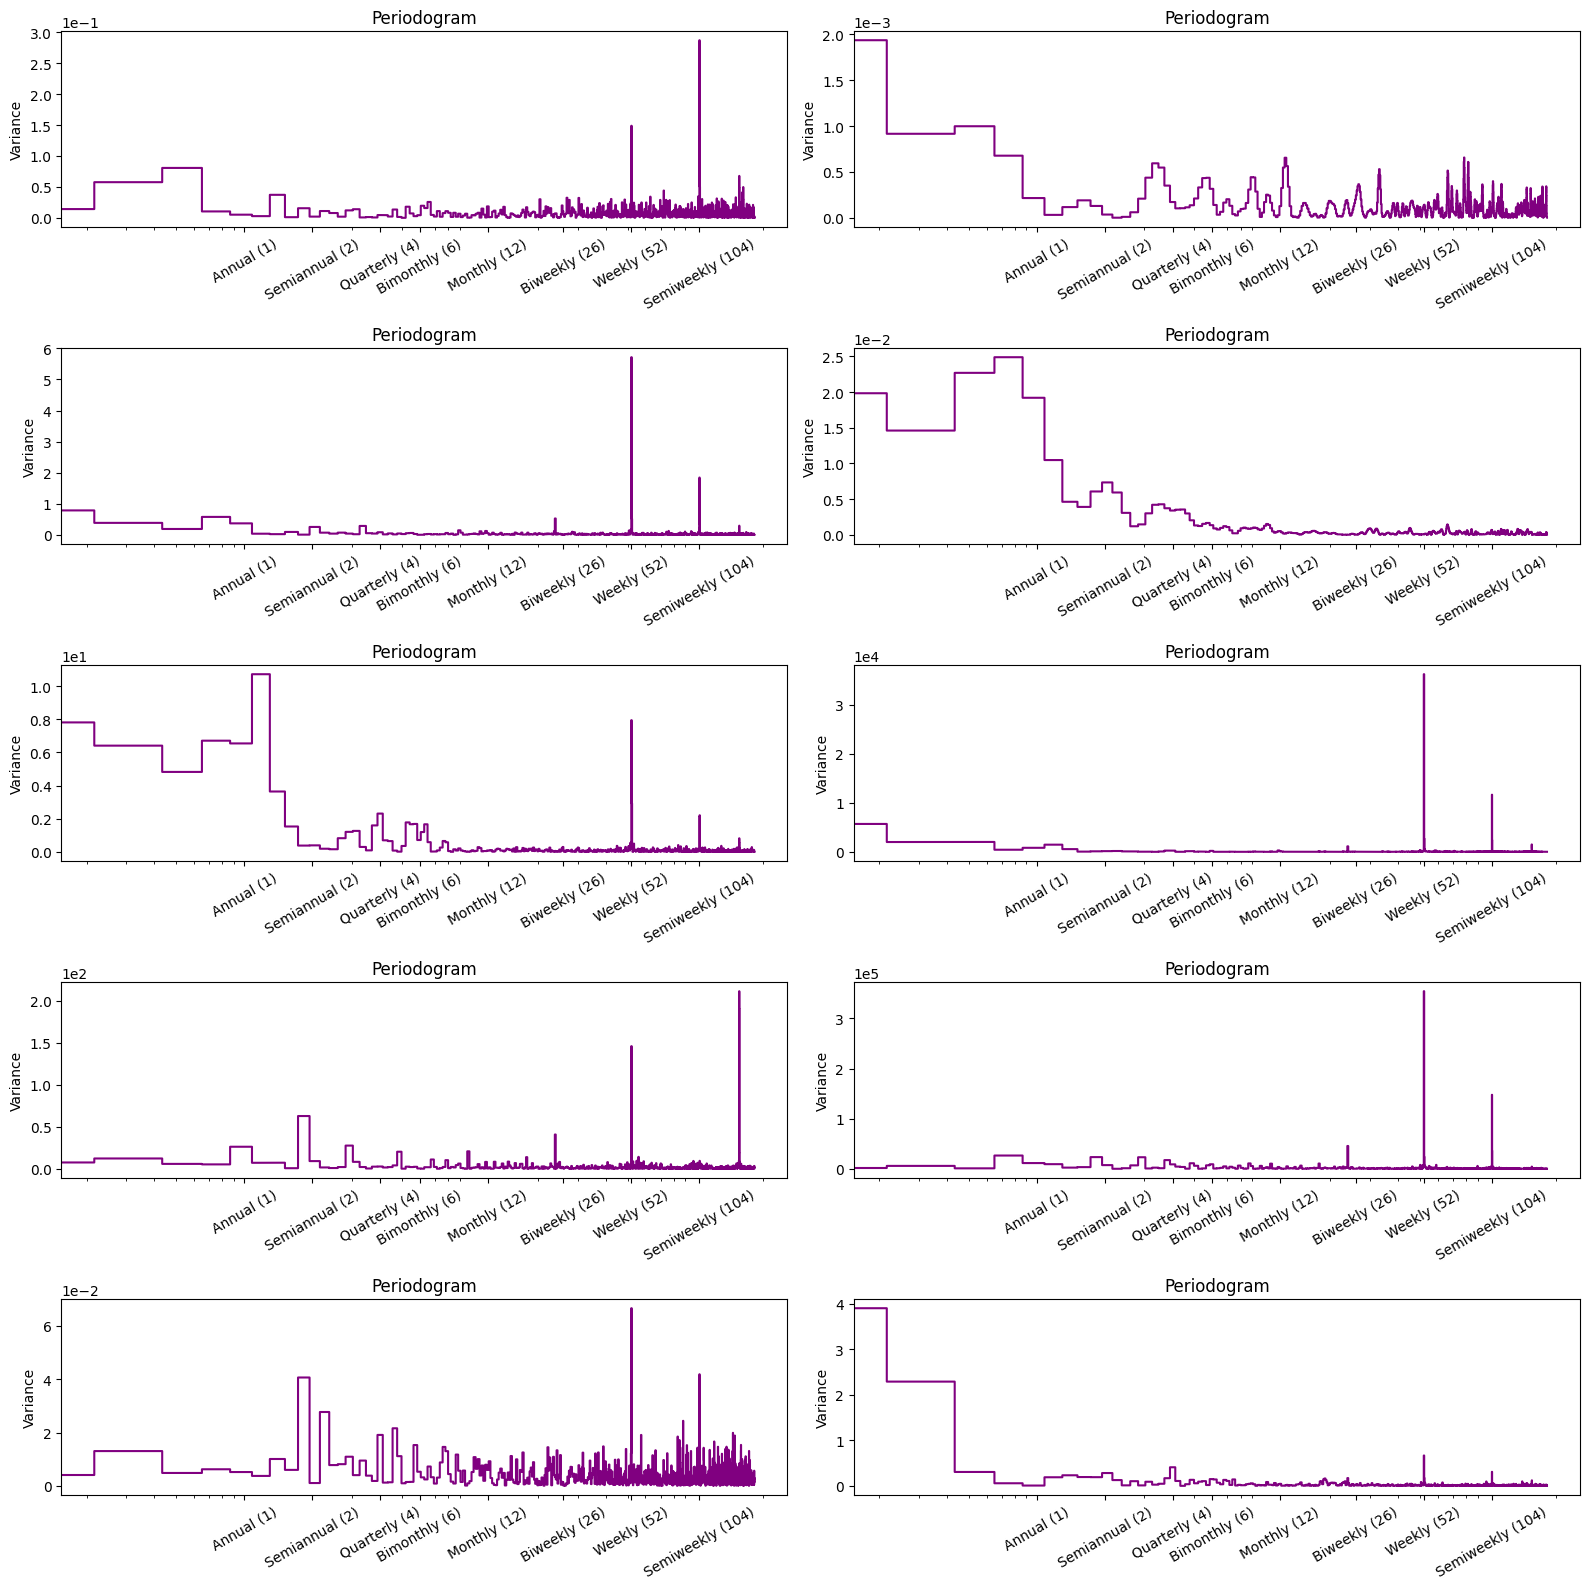

In [7]:
# plot periodogram for each store_family in subplots
fig, axes = plt.subplots(5, 2, figsize=(16, 16))
for i, ax in zip(['1_AUTOMOTIVE', '2_BABY CARE', '3_BEAUTY', '4_BOOKS', '5_CELEBRATION', '6_DAIRY', '7_EGGS', '8_GROCERY I', '9_HARDWARE', '10_HOME AND KITCHEN II'], axes.flatten()):
    plt.title(i)
    plot.plot_periodogram(df_data[df_data['store_family'] == i]['sales'], ax=ax)
plt.tight_layout()


- Conclusion: based on the periodograms above, use up to 26 Fourier features (52 pairs of sin/cos)
    - Some store_families have less
    - As a compromise, use 10 Fourier features

In [8]:
fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for Annual seasonality

# since all store_families have the same length, we can get Fourier Features for one store_family and then concatenate them for all store_families

dp = DeterministicProcess(
    index=df_data[df_data['store_family'] == '1_AUTOMOTIVE']['date'],
    constant=True,               # dummy feature for bias (y-intercept)
    order=0,                     # trend (order 1 means linear)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=False,                   # drop terms to avoid collinearity
)

X_train = dp.in_sample()  # create features for dates in tunnel.index

In [9]:
print(f'{X_train.shape=}')
display(X_train.head())

X_train.shape=(1688, 21)


,const,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630,0.085965,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2013-01-03,1.0,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532,0.171293,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
2013-01-04,1.0,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740,0.255353,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
2013-01-05,1.0,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309,0.337523,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157


In [10]:
# join X_train to df_data
df_data = df_data.merge(X_train, left_on='date', right_index=True, how='left')

display(df_data)


,family,store_nbr,date,sales,onpromotion,store_family,trend,year,month,day,...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
0,AUTOMOTIVE,1,2013-01-01,0.0,0,1_AUTOMOTIVE,0,2013,1,1,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,AUTOMOTIVE,1,2013-01-02,2.0,0,1_AUTOMOTIVE,1,2013,1,2,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2,AUTOMOTIVE,1,2013-01-03,3.0,0,1_AUTOMOTIVE,2,2013,1,3,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
3,AUTOMOTIVE,1,2013-01-04,3.0,0,1_AUTOMOTIVE,3,2013,1,4,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
4,AUTOMOTIVE,1,2013-01-05,5.0,0,1_AUTOMOTIVE,4,2013,1,5,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,SEAFOOD,54,2017-08-11,0.0,0,54_SEAFOOD,1683,2017,8,11,...,-0.806480,-0.591261,0.998880,-0.047321,-0.746972,0.664855,0.162807,-0.986658,0.493776,0.869589
3008012,SEAFOOD,54,2017-08-12,1.0,1,54_SEAFOOD,1684,2017,8,12,...,-0.863142,-0.504961,0.985948,-0.167052,-0.648630,0.761104,0.008607,-0.999963,0.635432,0.772157
3008013,SEAFOOD,54,2017-08-13,2.0,0,54_SEAFOOD,1685,2017,8,13,...,-0.910605,-0.413279,0.958718,-0.284359,-0.538005,0.842942,-0.145799,-0.989314,0.758306,0.651899
3008014,SEAFOOD,54,2017-08-14,0.0,0,54_SEAFOOD,1686,2017,8,14,...,-0.948362,-0.317191,0.917584,-0.397543,-0.417194,0.908818,-0.296713,-0.954967,0.858764,0.512371


- **Cyclicality Features**
    - Lag Features
    - Average of the last 4 weeks on the same day

In [11]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_4371/4075833985.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


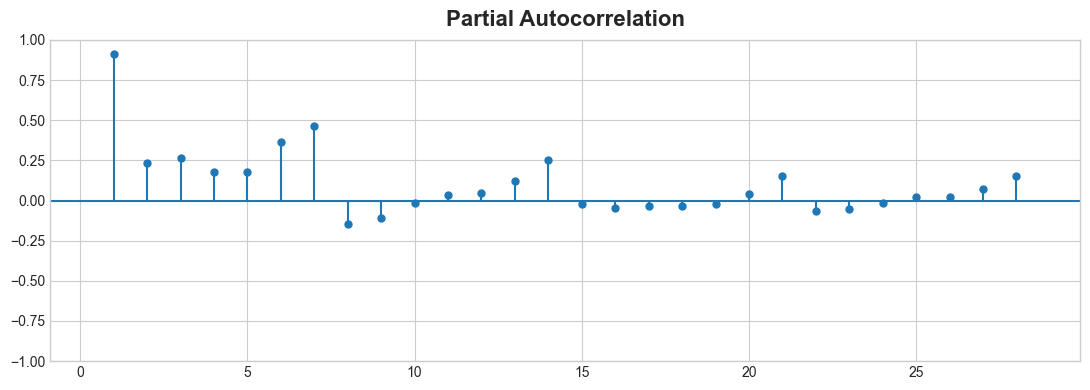

In [12]:
# _ = plot_lags(df_data.sales, lags=12, nrows=2)
_ = plot_pacf(df_data.sales, lags=28, method="ywm", zero=False)

- Conclusion: Looks like lag 1 - 7, 14, 21, 28 are significant. We will combine the results from the Mutual Information exercise to determine which lags to keep, and which ones to discard

In [13]:
# add lag features using the sales column
for i in tqdm(range(1, 29)): # 4 weeks
    df_data[f'sales_lag_{i}'] = df_data.groupby(['store_family'])['sales'].shift(i)    

print(f'{df_data.shape=}')
df_data.head()

100%|██████████| 28/28 [00:02<00:00,  9.75it/s]

df_data.shape=(3008016, 64)


,family,store_nbr,date,sales,onpromotion,store_family,trend,year,month,day,...,sales_lag_19,sales_lag_20,sales_lag_21,sales_lag_22,sales_lag_23,sales_lag_24,sales_lag_25,sales_lag_26,sales_lag_27,sales_lag_28
0,AUTOMOTIVE,1,2013-01-01,0.0,0,1_AUTOMOTIVE,0,2013,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AUTOMOTIVE,1,2013-01-02,2.0,0,1_AUTOMOTIVE,1,2013,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AUTOMOTIVE,1,2013-01-03,3.0,0,1_AUTOMOTIVE,2,2013,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AUTOMOTIVE,1,2013-01-04,3.0,0,1_AUTOMOTIVE,3,2013,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AUTOMOTIVE,1,2013-01-05,5.0,0,1_AUTOMOTIVE,4,2013,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# average sales from past 4 weeks on the same day of the week
df_data['average_sales_last_4_weeks'] = df_data[[f'sales_lag_7', f'sales_lag_14', f'sales_lag_21', f'sales_lag_28']].mean(axis=1)

- **Add other exogenous features**
    - Store metadata
    - Holidays
    - Oil price

In [15]:
# join store data to df_data
# rename store tpye column to avoid name conflict
df_stores.rename(columns={'type': 'store_type'}, inplace=True)
df_data = df_data.merge(df_stores, on='store_nbr', how='left')

# join holiday data to df_data
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
# rename holiday type column to avoid name conflict
df_holidays.rename(columns={'type': 'holiday_type'}, inplace=True)
df_data = df_data.merge(df_holidays, left_on=['city', 'date'], right_on=['locale_name', 'date'],  how='left')

# join transaction data to df_data
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_data = df_data.merge(df_transactions, on=['date', 'store_nbr'], how='left')
# add lag features using the transactions column
for i in tqdm(range(1, 29)): # 4 weeks
    df_data[f'transactions_lag_{i}'] = df_data.groupby(['store_family'])['transactions'].shift(i)

# join oil data to df_data
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_data = df_data.merge(df_oil, on='date', how='left')
# add lag features using oil column
for i in tqdm(range(1, 29)): # 4 weeks
    df_data[f'oil_lag_{i}'] = df_data.groupby(['store_family'])['dcoilwtico'].shift(i)


100%|██████████| 28/28 [00:02<00:00,  9.87it/s]


In [16]:
print(f'{df_data.shape=}')
df_data.head()

# save df_data to csv
df_data.to_csv('data/training/df_data_tabular.csv', index=False)

df_data.shape=(3008016, 132)


# Check missing values

In [17]:
# check missing values percentage
df_data.isna().sum() / df_data.shape[0]

family         0.000000
store_nbr      0.000000
date           0.000000
sales          0.000000
onpromotion    0.000000
                 ...   
oil_lag_24     0.014218
oil_lag_25     0.014810
oil_lag_26     0.015403
oil_lag_27     0.015995
oil_lag_28     0.016588
Length: 132, dtype: float64

In [18]:
# split data prior to filling missing values and MI (to avoid data leakage)
df_data, target, _, _ = data_split.train_test_split(df_data, cutoff_date='2017-01-01', target_column_name='sales')

In [19]:
# fill missing values with mean
# numerical
df_data.fillna(df_data.mean(numeric_only=True), inplace=True)
# categorical
df_data.fillna(df_data.mode(), inplace=True)

# Mutual Information
- Determine which features are most important for predicting the target

In [20]:
df_data['sales'] = target
# Label encoding for categoricals
X = df_data[(df_data['year'] == 2016)].drop(columns=["date"])
y = X.pop("sales")

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [22]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

average_sales_last_4_weeks    1.727074
sales_lag_14                  1.557371
sales_lag_1                   1.480142
sales_lag_13                  1.371216
sales_lag_20                  1.347069
sales_lag_5                   1.322281
sales_lag_4                   1.297989
sales_lag_19                  1.275848
sales_lag_26                  1.265274
sales_lag_18                  1.250207
family                        1.159929
transactions                  0.113788
transactions_lag_1            0.091300
transactions_lag_28           0.084461
transactions_lag_3            0.080618
transactions_lag_13           0.079917
transactions_lag_5            0.078513
transactions_lag_20           0.077293
transactions_lag_16           0.075916
city                          0.073986
transactions_lag_19           0.073642
transactions_lag_25           0.072241
trend                         0.016015
oil_lag_4                     0.013093
oil_lag_12                    0.012458
oil_lag_17               

In [23]:
# saves to series to csv
mi_scores.to_csv('data/mi_scores/mi_scores.csv')

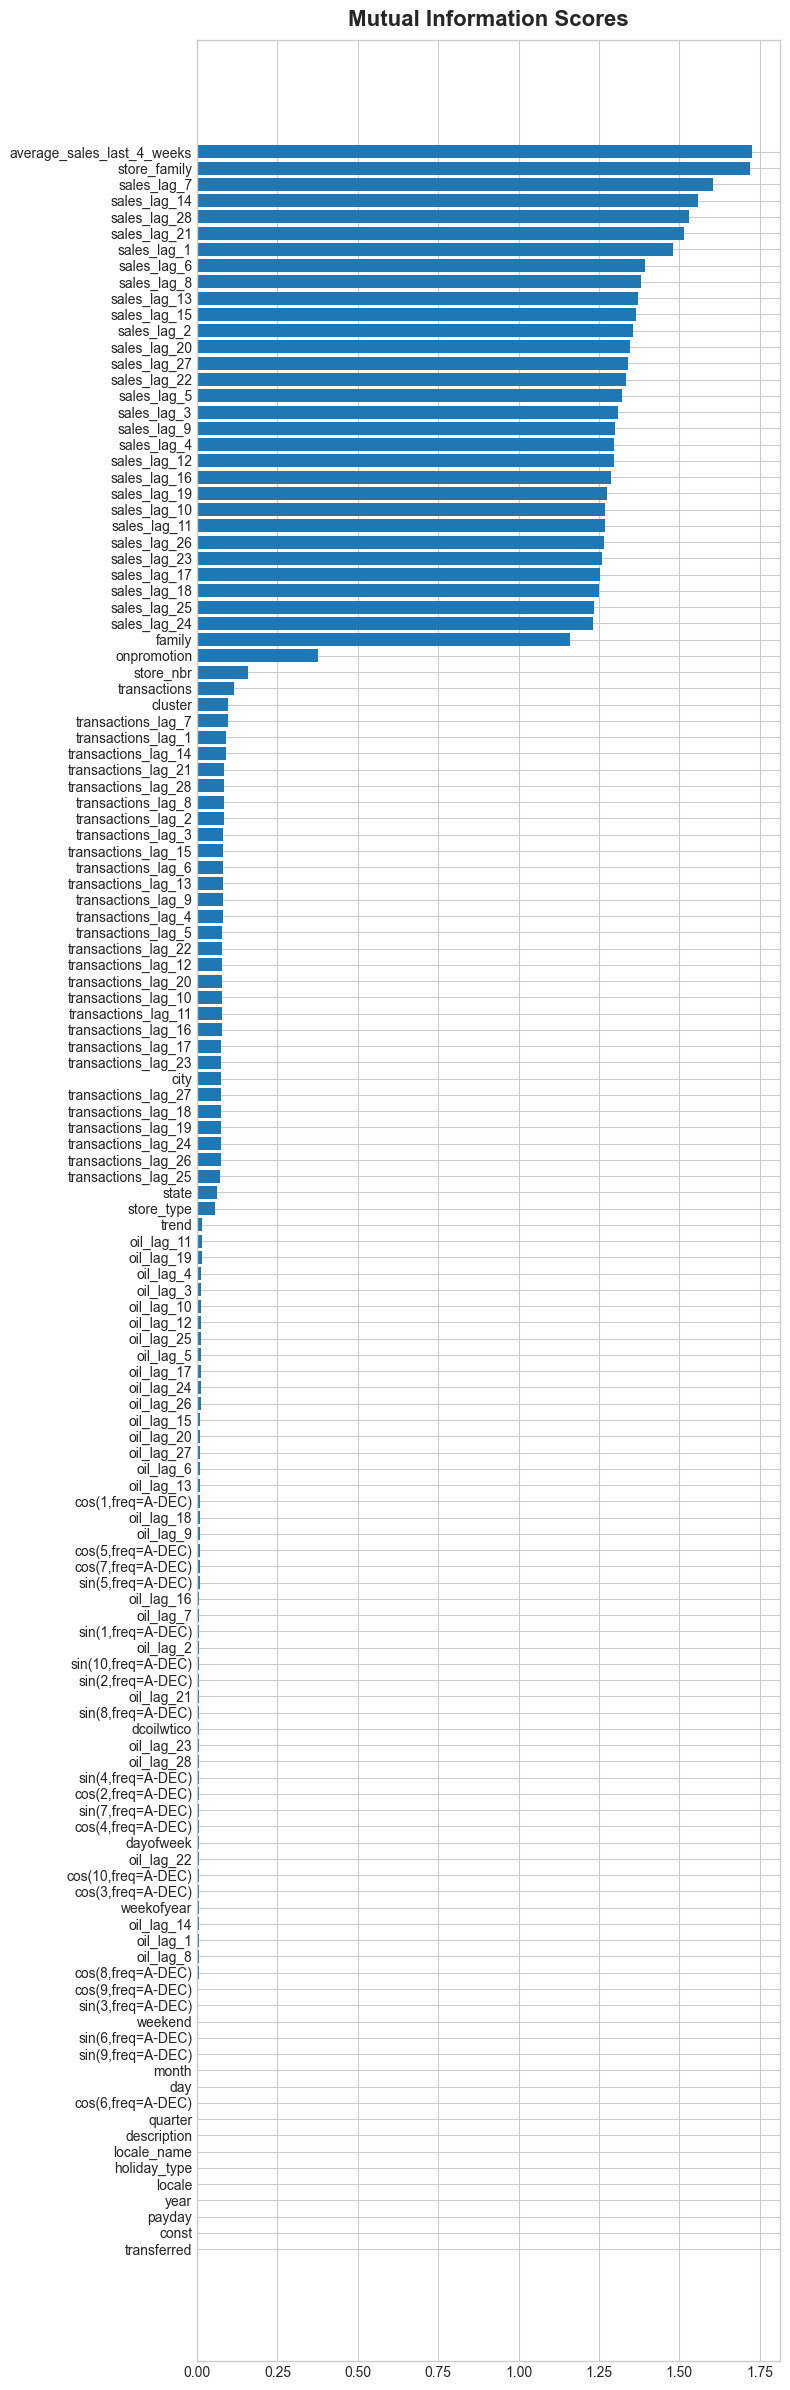

In [24]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 24))
plot_mi_scores(mi_scores)

# save plot
plt.savefig('plots/mi_scores.png', bbox_inches='tight')

# Summary
1. The most important features are the lagged sales, followed by the lagged transactions and lagged oil prices.
2. The store_family is the most important categorical feature, followed by onpromotion
3. The day of the week is the most important temporal feature
4. The average sales from the last 4 weeks is the most important feature that is not a lagged sales
5. Fourier features do not seem to be very important (relatively speaking)

**Note**: Sometimes, a feature may be very useful when interacting with other features, but less so on its own. Mutual information is not able to detect these interactions between features, as it is a univariate metric that only considers one feature at a time.

